In [ ]:
!pip install yfinance

In [ ]:
import os
from datasets import load_dataset
import pandas as pd
import numpy as np
from datetime import datetime
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import yfinance as yf
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


c:\Users\avane\OneDrive\Desktop\coding\DBMS\retail_banking_system\backend\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

dataset = 'groww_reviews_last5y.csv'
df = pd.read_csv(dataset)
print('Rows:', len(df))
df.head(10)


Rows: 322726


C:\Users\avane\AppData\Local\Temp\ipykernel_14880\11621325.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset)


,reviewId,content,score,at,userName,thumbsUpCount,appVersion
0,ce656ac6-f9d9-45f8-86af-22b8f58c6cb7,nice,5,2025-09-26T13:13:25+00:00,A Google user,0,17.94.1
1,d606d2ff-9c90-4bce-9bea-d939d6363603,best,5,2025-09-26T12:43:57+00:00,A Google user,0,NaN
2,4b7d583c-0200-406d-839f-4de7adb1d1ff,good,5,2025-09-26T11:59:29+00:00,A Google user,0,17.94.1
3,fd6f5a01-8023-406d-8d4c-0876ed3fc3c3,very nice app,5,2025-09-26T11:46:07+00:00,A Google user,0,17.92.3
4,09d47167-fb12-4ba5-842e-611629fb5e60,The new update is awesome. also provides Greek...,5,2025-09-26T11:45:53+00:00,A Google user,0,17.94.1
5,d2f34c53-1709-4efb-a30e-ca48377a7c0a,great,5,2025-09-26T11:10:35+00:00,A Google user,0,17.94.1
6,bf6de73d-a45a-4328-9ffc-66e61b250fed,trading charges are very high,3,2025-09-26T10:56:44+00:00,A Google user,0,17.94.1
7,079d1972-e08d-434e-9fbf-c21d4cfded92,nice app,5,2025-09-26T10:35:52+00:00,A Google user,0,17.94.1
8,102a3691-c1a7-4f95-8495-b0dd11cb2791,best for me,5,2025-09-26T10:34:09+00:00,A Google user,0,17.94.1
9,b077ca88-cf05-4a9f-9698-44cd1ca369d1,nice,5,2025-09-26T10:14:10+00:00,A Google user,0,17.94.1


In [ ]:

df['at_parsed'] = pd.to_datetime(df['at'], utc=True, errors='coerce')
df = df[df['content'].notna()].copy()
df['date'] = df['at_parsed'].dt.date
df['year_month'] = df['at_parsed'].dt.to_period('M')
df['weekday'] = df['at_parsed'].dt.weekday
print(df[['content','score','at','at_parsed']].head(3))


  content  score                         at                 at_parsed
0    nice      5  2025-09-26T13:13:25+00:00 2025-09-26 13:13:25+00:00
1    best      5  2025-09-26T12:43:57+00:00 2025-09-26 12:43:57+00:00
2    good      5  2025-09-26T11:59:29+00:00 2025-09-26 11:59:29+00:00


C:\Users\avane\AppData\Local\Temp\ipykernel_14880\3077920803.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['at_parsed'].dt.to_period('M')


## Sentiment analysis (FinBERT)
The next cells load your FinBERT model and run sentiment analysis.

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset
import pandas as pd
from tqdm.auto import tqdm


MODEL_DIR = "finetuned-finbert"   
BATCH_SIZE = 128                 
NUM_WORKERS = 0                  
MAX_LENGTH = 512               
USE_FP16 = True                  
TEXT_COL = "content"              

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

id2label = getattr(model.config, "id2label", None)
if id2label is None:
    id2label = {0: "LABEL_0", 1: "LABEL_1"} if model.config.num_labels == 2 else {i: f"LABEL_{i}" for i in range(model.config.num_labels)}
print("Model num_labels:", model.config.num_labels)
print("id2label example:", {k:id2label[k] for k in list(id2label)[:min(5,len(id2label))]})

ds = Dataset.from_pandas(df[[TEXT_COL]].reset_index())  
def tokenize_fn(batch):
    return tokenizer(batch[TEXT_COL], truncation=True, max_length=MAX_LENGTH)
ds = ds.map(tokenize_fn, batched=True, remove_columns=[TEXT_COL]) 

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator, num_workers=NUM_WORKERS)

all_top_labels = []
all_top_scores = []
all_probs = []  

use_amp = (device.type == "cuda") and USE_FP16
autocast = torch.cuda.amp.autocast if use_amp else torch.cpu.amp.autocast 

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Inference"):
        batch = {k: v.to(device) for k,v in batch.items() if k in ("input_ids","attention_mask","token_type_ids")}
        with autocast():
            outputs = model(**batch)
            logits = outputs.logits  
            probs = F.softmax(logits, dim=-1)

        
        top_scores, top_idx = torch.max(probs, dim=-1)
        top_scores = top_scores.cpu().tolist()
        top_idx = top_idx.cpu().tolist()

       
        all_top_labels.extend([ id2label[i] if i in id2label else str(i) for i in top_idx ])
        all_top_scores.extend(top_scores)
        all_probs.extend(probs.cpu().tolist()) 

results_df = pd.DataFrame({
    "index": ds["index"],
    "sent_label_raw": all_top_labels,
    "sent_score": all_top_scores,
})

num_labels = model.config.num_labels
if len(all_probs) > 0:
    probs_arr = pd.DataFrame(all_probs, columns=[id2label[i] for i in range(num_labels)])
    probs_arr["index"] = ds["index"]
    results_df = results_df.merge(probs_arr, on="index")

df_out = df.reset_index().merge(results_df, left_on="index", right_on="index", how="left").set_index("index")
def standardize_label(l):
    if not isinstance(l, str): return l
    s = l.lower()
    if "neg" in s or s.startswith("label_0") or s.startswith("0"):
        return "negative"
    if "neu" in s or s.startswith("label_1") or s.startswith("1"):
        return "neutral"
    if "pos" in s or s.startswith("label_2") or s.startswith("2"):
        return "positive"
    return l

df_out["sent_standard"] = df_out["sent_label_raw"].apply(standardize_label)
df["sent_label_raw"] = df_out["sent_label_raw"]
df["sent_score"] = df_out["sent_score"]
df["sent_standard"] = df_out["sent_standard"]

print("Done. Sample:")
print(df[['content','sent_label_raw','sent_score','sent_standard']].head())


Device: cuda
Model num_labels: 3
id2label example: {0: 'positive', 1: 'negative', 2: 'neutral'}


Inference:   0%|          | 0/2522 [00:00<?, ?it/s]C:\Users\avane\AppData\Local\Temp\ipykernel_14880\3757383948.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Inference: 100%|██████████| 2522/2522 [12:57<00:00,  3.24it/s]


Done. Sample:
                                             content sent_label_raw  \
0                                               nice        neutral   
1                                               best        neutral   
2                                               good       positive   
3                                      very nice app        neutral   
4  The new update is awesome. also provides Greek...       positive   

   sent_score sent_standard  
0    0.918569       neutral  
1    0.921637       neutral  
2    0.981544      positive  
3    0.605590       neutral  
4    0.985073      positive  


In [28]:
df[['content','sent_label_raw','sent_score','sent_standard']].head(10)

,content,sent_label_raw,sent_score,sent_standard
0,nice,neutral,0.918569,neutral
1,best,neutral,0.921637,neutral
2,good,positive,0.981544,positive
3,very nice app,neutral,0.605590,neutral
4,The new update is awesome. also provides Greek...,positive,0.985073,positive
5,great,neutral,0.602729,neutral
6,trading charges are very high,neutral,0.799192,neutral
7,nice app,neutral,0.892500,neutral
8,best for me,positive,0.793770,positive
9,nice,neutral,0.918569,neutral


In [ ]:
alpha = 0.0

def compute_stress(row):
    lab = row['sent_standard']
    sc = float(row['sent_score'] if not pd.isna(row['sent_score']) else 0)
    if lab == 'negative':
        return sc
    elif lab == 'neutral':
        return 0.0
    elif lab == 'positive':
        return -alpha * sc
    else:
        return 0.0

df['stress_raw'] = df.apply(compute_stress, axis=1)
daily = df.groupby('date').agg({'stress_raw':'mean','content':'count'}).rename(columns={'content':'n_reviews'})
daily = daily.sort_index()
daily['stress_rolling7'] = daily['stress_raw'].rolling(7, min_periods=1).mean()

daily.reset_index().head()


,date,stress_raw,n_reviews,stress_rolling7
0,2020-09-28,0.024890,151,0.024890
1,2020-09-29,0.017377,256,0.021133
2,2020-09-30,0.012903,232,0.018390
3,2020-10-01,0.017923,303,0.018273
4,2020-10-02,0.022871,258,0.019193


In [33]:
df.to_csv(dataset[:-4]+'_preds.csv')

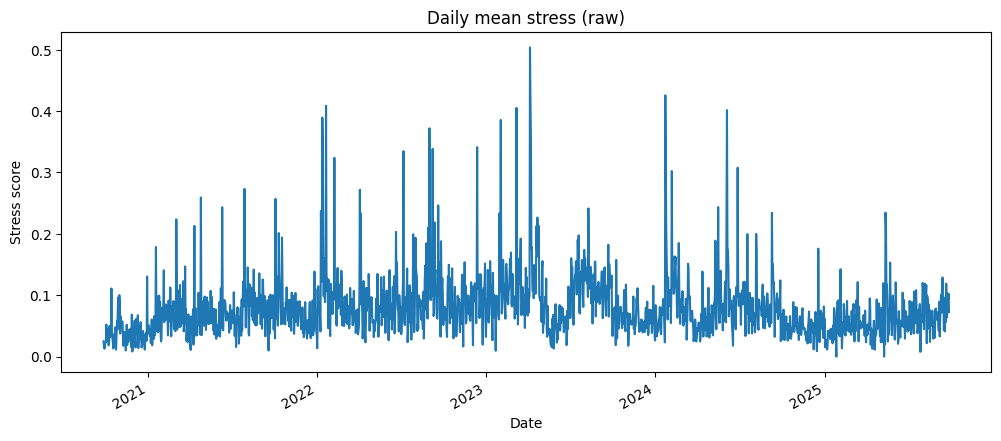

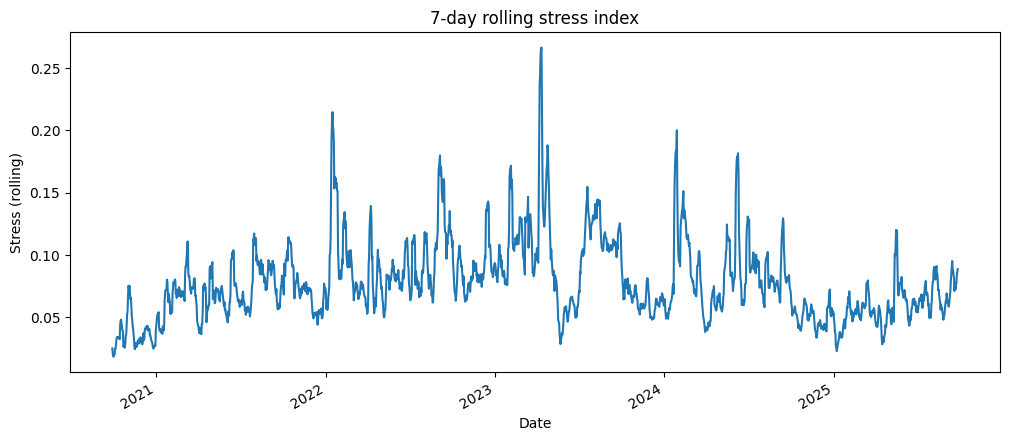

In [34]:

# 6. Plot time-series of stress
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
plt.plot(daily.index, daily['stress_raw'])
plt.title('Daily mean stress (raw)')
plt.xlabel('Date')
plt.ylabel('Stress score')
plt.gcf().autofmt_xdate()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(daily.index, daily['stress_rolling7'])
plt.title('7-day rolling stress index')
plt.xlabel('Date')
plt.ylabel('Stress (rolling)')
plt.gcf().autofmt_xdate()
plt.show()


In [ ]:

ticker = '^NSEI'
start = daily.index.min().strftime('%Y-%m-%d')
end = daily.index.max().strftime('%Y-%m-%d')

try:
    market = yf.download(ticker, start=start, end=end)

    market['date'] = market.index.date
    market_daily = market.groupby('date').agg({'Close':'last','Open':'first','High':'max','Low':'min','Volume':'sum'})
    market_daily['return'] = market_daily['Close'].pct_change()
    merged = pd.merge(daily.reset_index(), market_daily.reset_index(), left_on='date', right_on='date', how='inner')
    merged.set_index('date', inplace=True)
    print('Merged rows:', len(merged))
    print(merged[['stress_raw','return']].corr())
except Exception as e:
    print('Market fetch error:', e)
    merged = None


C:\Users\avane\AppData\Local\Temp\ipykernel_14880\105912482.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^NSEI']: Timeout('Failed to perform, curl: (28) Failed to connect to query1.finance.yahoo.com port 443 after 21037 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Market fetch error: "Column(s) ['Close', 'High', 'Low', 'Open', 'Volume'] do not exist"


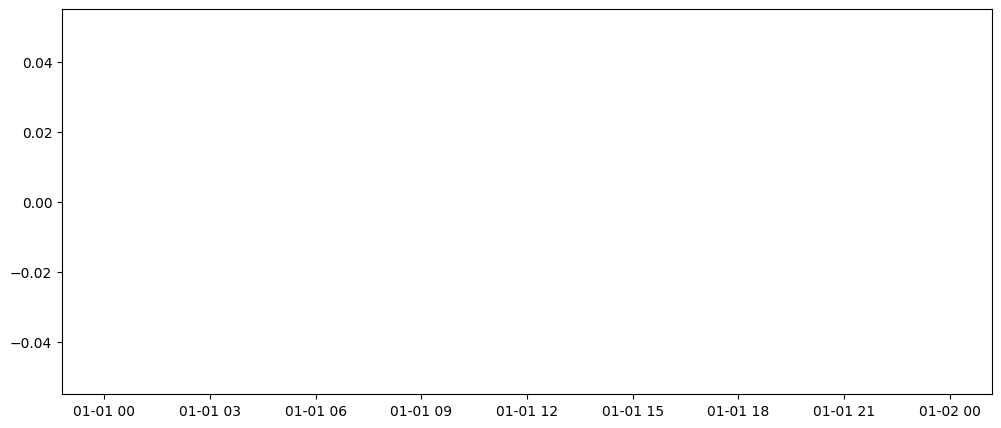

In [24]:
plt.figure(figsize=(12,5))
plt.plot(market.index, market['Volume'])
plt.show()